# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from tqdm.notebook import tqdm

Mounted at /content/drive


In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


# Seeds
import random, os
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Preprocessing

In [2]:
def preprocess_stock_new(df_raw, train_frac: float, val_frac: float):
    minutely = df_raw.copy()

    # turn column to datetime, add helper day column
    minutely["Date Time"] = pd.to_datetime(minutely["Date Time"])
    minutely = minutely.sort_values("Date Time")
    minutely["day"] = minutely["Date Time"].dt.date

    # minutely log returns withing days from close
    minutely["log_close"] = np.log(minutely["Close"].astype(float))
    minutely["ret_1m"] = minutely.groupby("day")["log_close"].diff()
    # remove first minute of each day without returns
    minutely = minutely[minutely["Date Time"].dt.time != pd.to_datetime("09:35").time()]

    # Calculate the RV for each grouped 380 row day
    group_sums = minutely.groupby("day")["ret_1m"].transform(lambda x: np.sum(x**2))

    # Add the group sums as a new column
    minutely["realized_vol"] = group_sums
    minutely["log_rv"] = np.log(minutely["realized_vol"].replace(0.0, 1e-12))
    minutely = minutely.reset_index(drop=True)

    # calculate train test split; make sure no day is cut in half between the two data splits
    train_idx = int(np.floor(minutely.shape[0] * train_frac / 380) * 380)
    val_idx = int(np.floor(minutely.shape[0] * val_frac / 380) * 380)
    # Split the DataFrame into training and testing sets
    df_train = minutely.iloc[:train_idx]
    df_val = minutely.iloc[train_idx:train_idx+val_idx]
    df_test = minutely.iloc[train_idx+val_idx:]

    return df_train, df_val, df_test

In [29]:
def create_sequences_array_residual(df, n_days):
    # create lists to fill with subsequences and their Realized Volatility targets
    sequence_list = []
    sequence_target_residual = []
    sequence_targe_true_RV = []

    # Loop through the DataFrame to create subsequences
    for i in range(int(len(df)/380-n_days)):

        # Extract a subsequence of 21 days (each day with 380 rows)
        tmp_subsequence = df.iloc[i * 380: (n_days + i) * 380]
        arr = tmp_subsequence["ret_1m"].to_numpy()

        arr = arr.reshape(1, 380*n_days, 1)
        sequence_list.append(arr)

        # Try to get the target value for the current subsequence
        try:
            target_day_log_rv = df.iloc[(n_days + i) * 380]["log_rv"]
            previous_day_log_rv = df.iloc[(n_days + i) * 380 - 1]["log_rv"]
            subsequence_target = target_day_log_rv - previous_day_log_rv
            
            sequence_target_residual.append(subsequence_target)
            sequence_targe_true_RV.append(target_day_log_rv)
        except:
            # Print a message if an IndexError occurs (likely in the last iteration)
            # since the last 21 day window doesn't have a RV target
            print("last iteration")


    arr = np.vstack(sequence_list)
    
    return arr, np.array(sequence_target_residual), np.array(sequence_targe_true_RV)

In [30]:
train, val, test = preprocess_stock_new(pd.read_csv("data/Amgen.csv"), train_frac= 0.7, val_frac = 0.15)

In [31]:
out = create_sequences_array_residual(train, 2)

In [39]:
train.iloc[758:765]

,Date Time,Open,High,Low,Close,Volume,Date,Time,day,log_close,ret_1m,realized_vol,log_rv
758,2010-01-05 15:54:00,43.9093,43.9093,43.9017,43.9093,29826.0,2010-01-05,15:54:00,2010-01-05,3.782126,0.000000,0.000141,-8.869798
759,2010-01-05 15:55:00,43.9093,43.9553,43.9017,43.9400,71095.0,2010-01-05,15:55:00,2010-01-05,3.782825,0.000699,0.000141,-8.869798
760,2010-01-06 09:36:00,43.7943,43.8327,43.7560,43.7675,17194.0,2010-01-06,09:36:00,2010-01-06,3.778892,-0.000612,0.000088,-9.332600
761,2010-01-06 09:37:00,43.7867,43.7943,43.7407,43.7867,11891.0,2010-01-06,09:37:00,2010-01-06,3.779330,0.000439,0.000088,-9.332600
762,2010-01-06 09:38:00,43.7713,43.8403,43.7713,43.8327,9200.0,2010-01-06,09:38:00,2010-01-06,3.780380,0.001050,0.000088,-9.332600
763,2010-01-06 09:39:00,43.8403,43.8557,43.7790,43.8173,19475.0,2010-01-06,09:39:00,2010-01-06,3.780029,-0.000351,0.000088,-9.332600
764,2010-01-06 09:40:00,43.8250,43.8403,43.7637,43.7637,9645.0,2010-01-06,09:40:00,2010-01-06,3.778805,-0.001224,0.000088,-9.332600


In [40]:
-9.332600 - -8.869798

-0.46280199999999994

In [41]:
out = create_sequences_array_residual(train, 2)
out[1]
out[2][1:4]
rolled = np.roll(out[2], 1)
recovered = rolled[1:] + out[1][1:]
recovered[:3]

array([-0.46280161,  1.03097037, -0.899466  , ...,  0.68986568,
        0.08634146, -0.07702247])

In [49]:
out[2][1:4]

array([-8.30162914, -9.20109514, -9.3457952 ])

In [45]:
rolled = np.roll(out[2], 1)

In [46]:
recovered = rolled[1:] + out[1][1:]

In [47]:
recovered[:3]

array([-8.30162914, -9.20109514, -9.3457952 ])

In [3]:
def create_sequences_array(df, n_days):
    # create lists to fill with subsequences and their Realized Volatility targets
    sequence_list = []
    sequence_target = []

    # Loop through the DataFrame to create subsequences
    for i in range(int(len(df)/380-n_days)):

        # Extract a subsequence of 21 days (each day with 380 rows)
        tmp_subsequence = df.iloc[i * 380: (n_days + i) * 380]
        arr = tmp_subsequence["ret_1m"].to_numpy()

        arr = arr.reshape(1, 380*n_days, 1)
        sequence_list.append(arr)

        # Try to get the target value for the current subsequence
        try:
            subsequence_target = df.iloc[(n_days + i) * 380]["log_rv"]
            sequence_target.append(subsequence_target)
        except:
            # Print a message if an IndexError occurs (likely in the last iteration)
            # since the last 21 day window doesn't have a RV target
            print("last iteration")


    arr = np.vstack(sequence_list)

    return arr, np.array(sequence_target)

In [4]:
def scaler(X_train, X_val, X_test_dic, d):

    mu = X_train[:, :, :d].mean(axis=(0, 1), keepdims=True)
    sd = X_train[:, :, :d].std(axis=(0, 1), keepdims=True) + 1e-8

    def scale(X):
        X_scaled = X.copy()
        X_scaled[:, :, :d] = (X_scaled[:, :, :d] - mu) / sd
        return X_scaled

    X_train = scale(X_train)
    X_val   = scale(X_val)

    # loop through test dict
    X_test_scaled = {stock: scale(arr) for stock, arr in X_test_dic.items()}

    return X_train, X_val, X_test_scaled

# CUDA Model/Trainer

In [5]:
# ---- CUDA-only loader: pinned memory + persistent workers ----
def mk_loader(X, y, bs=64, shuffle=False, num_workers=2):
    x_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(x_t, y_t)
    return DataLoader(
        ds, batch_size=bs, shuffle=shuffle,
        pin_memory=True, num_workers=num_workers,
        persistent_workers=(num_workers > 0)
    )

In [6]:
# ---- Tiny Transformer with learnable positional embeddings ----
class VolTransformerTiny(nn.Module):
    def __init__(self, d_in, d_model=128, nhead=4, num_layers=3,
                 p_drop=0.1, use_cls=True, ff_mult=4, max_len=4096):
        super().__init__()
        self.use_cls = use_cls
        self.embed = nn.Linear(d_in, d_model)

        # positional embedding for tokens (add +1 for CLS position)
        self.pos_emb = nn.Embedding(max_len + 1, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=ff_mult*d_model,
            dropout=p_drop, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        if use_cls:
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.normal_(self.cls, mean=0.0, std=0.02)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(p_drop),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):  # x: [B, L, d_in]
        B, L, _ = x.shape
        h = self.embed(x)  # [B, L, d_model]

        # add positional embeddings
        # if CLS is used, its position index = 0, the rest shifted by +1
        if self.use_cls:
            pos_idx = torch.arange(1, L+1, device=x.device).unsqueeze(0).expand(B, -1)
            h = h + self.pos_emb(pos_idx)
            cls = self.cls.expand(B, -1, -1)
            # CLS gets position 0
            h = torch.cat([cls, h], dim=1)  # [B, L+1, d_model]
            h = h + torch.cat([self.pos_emb(torch.zeros(B,1, dtype=torch.long, device=x.device)),
                               torch.zeros_like(h[:,1:])], dim=1)
        else:
            pos_idx = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, -1)
            h = h + self.pos_emb(pos_idx)

        h = self.encoder(h)
        pooled = h[:, 0] if self.use_cls else h.mean(dim=1)
        return self.head(pooled).squeeze(-1)


In [7]:
# ---- CUDA-only trainer with AMP ----
def train_model_cuda(Xtr, ytr, Xva, yva, *,
                     d_model=128, nhead=4, num_layers=3,
                     batch_size=64, lr=1e-3, max_epochs=50,
                     weight_decay=1e-2, p_drop=0.1, patience=10,
                     ff_mult=4, ModelClass=None):
    assert torch.cuda.is_available(), "CUDA expected on Colab GPU runtime"
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True  # speed up for fixed shapes

    # Data
    train_loader = mk_loader(Xtr, ytr, bs=batch_size, shuffle=True)
    val_loader   = mk_loader(Xva, yva, bs=batch_size, shuffle=False)

    # Model
    if ModelClass is None:
        ModelClass = VolTransformerTiny  # use your class defined elsewhere
    model = ModelClass(
        d_in=Xtr.shape[-1], d_model=d_model, nhead=nhead,
        num_layers=num_layers, p_drop=p_drop, ff_mult=ff_mult,
        max_len=max(Xtr.shape[1], Xva.shape[1]) + 1
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.amp.GradScaler("cuda")

    best_val, best_state, wait = float('inf'), None, 0

    for epoch in range(1, max_epochs + 1):
        # ---- train ----
        model.train()
        tr_loss, n = 0.0, 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            tr_loss += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss /= max(1, n)

        # ---- validate ----
        model.eval()
        va_loss, n = 0.0, 0
        with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
                va_loss += loss.item() * xb.size(0)
                n += xb.size(0)
        va_loss /= max(1, n)

        improved = va_loss < best_val
        print(f"Epoch {epoch:03d} | Train {tr_loss:.6f} | Val {va_loss:.6f}{' *' if improved else ''}")

        if improved:
            best_val = va_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
        print(f"Restored best model with validation loss: {best_val:.6f}")
    else:
        print("Warning: no improvement; returning final weights")

    return model

In [8]:
# ---- CUDA-only evaluation ----
def eval_mse_cuda(X, y, model, bs=64):
    device = torch.device("cuda")
    loader = mk_loader(X, y, bs=bs, shuffle=False)
    model.eval()
    tot, n = 0.0, 0
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            pred = model(xb)
            loss = F.mse_loss(pred, yb)
            tot += loss.item() * xb.size(0)
            n += xb.size(0)
    return tot / max(1, n)

# ---- CUDA-only prediction ----
def predict_array_cuda(X, model, bs=64):
    device = torch.device("cuda")
    loader = mk_loader(X, np.zeros(len(X), dtype=np.float32), bs=bs, shuffle=False)
    outs = []
    model.eval()
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        for xb, _ in loader:
            xb = xb.to(device, non_blocking=True)
            outs.append(model(xb).float().cpu().numpy())
    return np.concatenate(outs, axis=0)

# Traning FN

In [25]:
a = np.array((1,4,2))
b = np.array((6,3,2))

In [26]:
np.roll(a,1)

array([2, 1, 4])

In [52]:
def get_data_train_model(file_list, *, train_frac=0.7, val_frac=0.15,
                n_days_context=3,
                d_model=128, nhead=4, num_layers=3,
                batch_size=64, lr=1e-3, max_epochs=50, patience=10,
                save_dir="/content/drive/MyDrive/data"):
    # --- 1) build per-stock splits and remember lengths for later slicing ---
    Xtr_list, ytr_list = [], []
    Xva_list, yva_list = [], []
    Xte_list, yte_list = [], []
    names, te_lengths = [], []
    X_test_dic = {}
    y_test_dic = {}
    har_train = {}

    for path in file_list:
        df_raw = pd.read_csv(path)
        stock_name = os.path.splitext(os.path.basename(path))[0]
        print(stock_name)
        # time-based split per stock
        train_df, val_df, test_df = preprocess_stock_new(df_raw, train_frac, val_frac)

        # window into sequences (shape: [N, seq_len, feat_dim])
        X_tr, y_tr, train_RV = create_sequences_array_residual(train_df, n_days_context) # X_test, y_residual, y_full
        X_va, y_va, val_RV = create_sequences_array_residual(val_df, n_days_context)
        X_te, y_te, test_RV = create_sequences_array_residual(test_df, n_days_context)

        Xtr_list.append(X_tr); ytr_list.append(y_tr)
        Xva_list.append(X_va); yva_list.append(y_va)
        Xte_list.append(X_te); yte_list.append(y_te)
        X_test_dic[stock_name] = X_te
        y_test_dic[stock_name] = test_RV
        print(y_tr.shape, y_va.shape)
        har_train[stock_name] = np.concatenate((train_RV, val_RV))

        names.append(stock_name)
        te_lengths.append(len(X_te))

    # --- 2) concatenate across stocks to make one big dataset ---
    X_train = np.concatenate(Xtr_list, axis=0)
    y_train = np.concatenate(ytr_list, axis=0)
    X_val   = np.concatenate(Xva_list, axis=0)
    y_val   = np.concatenate(yva_list, axis=0)
    X_test = np.concatenate(Xte_list, axis=0)
    y_test = np.concatenate(yte_list, axis=0)

    # --- 3) scale AFTER concatenation: fit on big train, transform val + big test ---
    # NOTE: we call your existing scaler once so it fits on X_train and applies to val/test.
    X_train_scaled, X_val_scaled, X_test_dic_scaled = scaler(X_train, X_val, X_test_dic, 1)
    print(X_train_scaled.shape)
    print(X_val_scaled.shape)
    # --- 4) train once on the pooled dataset ---
    start_time = time.time()
    model = train_model_cuda(
        X_train_scaled, y_train, X_val_scaled, y_val,
        d_model=d_model, nhead=nhead, num_layers=num_layers,
        batch_size=batch_size, lr=lr, max_epochs=max_epochs, patience=patience
    )
    end_time = time.time()
    minutes = int((end_time - start_time) // 60)
    seconds = (end_time - start_time) % 60
    print(f"Training completed in {minutes} minutes and {seconds:.2f} seconds.")

    return model, X_test_dic_scaled, y_test_dic, har_train

In [ ]:
out = create_sequences_array_residual(train, 2)

In [54]:
out[1]

array([-0.46280161,  1.03097037, -0.899466  , ...,  0.68986568,
        0.08634146, -0.07702247])

In [55]:
out[2][1:4]

array([-8.30162914, -9.20109514, -9.3457952 ])

In [57]:
rolled = np.roll(out[2], 1)

In [58]:
recovered = rolled[1:] + out[1][1:]

In [59]:
recovered[:3]

array([-8.30162914, -9.20109514, -9.3457952 ])

In [61]:
def run_test(model, X_test_dic, y_test_dic):
    out = {}
    model_mse_counter = 0
    naive_mse_counter = 0
    for stock in X_test_dic.keys():
        stock_dic = {}

        y_test = y_test_dic[stock]

        residual_pred = predict_array_cuda(X_test_dic[stock], model)
        naive_pred = np.roll(y_test, 1)
        stock_pred = naive_pred + pred_residual
        
        test_mse = np.mean((stock_pred[1:] - y_test[1:])**2)
        naive_mse = np.mean((naive_pred[1:] - y_test[1:])**2)

        stock_dic["y_pred"] = stock_pred
        stock_dic["y_test"] = y_test
        stock_dic["transformer_MSE"] = test_mse
        stock_dic["naive_pred"] = naive_pred
        stock_dic["naive_MSE"] = naive_mse

        out[stock] = stock_dic
        model_mse_counter += test_mse
        naive_mse_counter += naive_mse

        make_plot(stock, stock_pred, y_test, test_mse, naive_mse, naive_pred)


        # remove if needed
        actual_residual = y_test[1:] - naive_pred[1:] # y_test[t] - y_test[t-1]
        plt.figure(figsize=(8, 6))
        plt.scatter(actual_residual, predicted_residual, alpha=0.5)
        plt.plot([-0.5, 0.5], [-0.5, 0.5], 'r--') # Add a line for reference (y=x)
        plt.title('Actual vs. Predicted Residuals')
        plt.xlabel('Actual Residual (True Change)')
        plt.ylabel('Predicted Residual (Model\'s Predicted Change)')
        plt.grid(True)
        plt.show()

    return out, model_mse_counter / len(X_test_dic), naive_mse_counter / len(X_test_dic)

In [15]:
def make_plot(stock, y_pred, y_test, test_mse, naive_mse, naive_pred):

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[1:], label="True log RV", alpha = 0.5, color="darkblue")
    plt.plot(y_pred[1:],   label="Transformer", alpha=1, color="darkorange")
    #plt.plot(naive_pred[1:], label="Naive", color="grey")
    plt.title(f"{stock} (Test) | Naive: {naive_mse:.4f} | Transformer: {test_mse:.4f}")
    plt.xlabel("Test days"); plt.ylabel("log Realized Volatility")
    plt.legend()
    #fig_path = os.path.join(save_dir, f"{stock_name}_dm{d_model}_h{nhead}_L{num_layers}_ctx{n_days_context}.png")
    #plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show(); plt.close()

In [143]:
result_dic["Amgen"].keys()

dict_keys(['y_pred', 'y_test', 'transformer_MSE', 'naive_pred', 'naive_MSE'])

In [166]:
test_list = ['/content/drive/MyDrive/data/stocks/Walmart.csv']
test_list.append('/content/drive/MyDrive/data/stocks/Chevron_corp.csv')
test_list.append('/content/drive/MyDrive/data/stocks/3M.csv')

In [129]:
data_folder = "/content/drive/MyDrive/data/stocks/"
stock_files = glob.glob(os.path.join(data_folder, "*.csv"))
stock_files

['/content/drive/MyDrive/data/stocks/Proctor_Gamble.csv',
 '/content/drive/MyDrive/data/stocks/United_Health.csv',
 '/content/drive/MyDrive/data/stocks/Microsoft.csv',
 '/content/drive/MyDrive/data/stocks/Disney.csv',
 '/content/drive/MyDrive/data/stocks/Boeing.csv',
 '/content/drive/MyDrive/data/stocks/Honeywell.csv',
 '/content/drive/MyDrive/data/stocks/Intel.csv',
 '/content/drive/MyDrive/data/stocks/Home_Depot.csv',
 '/content/drive/MyDrive/data/stocks/Salesforce.csv',
 '/content/drive/MyDrive/data/stocks/Verizon_Communications.csv',
 '/content/drive/MyDrive/data/stocks/Merck_Co.csv',
 '/content/drive/MyDrive/data/stocks/Johnson_Johnson.csv',
 '/content/drive/MyDrive/data/stocks/Travelers.csv',
 '/content/drive/MyDrive/data/stocks/Apple.csv',
 '/content/drive/MyDrive/data/stocks/IBM.csv',
 '/content/drive/MyDrive/data/stocks/Caterpillar.csv',
 '/content/drive/MyDrive/data/stocks/McDonalds.csv',
 '/content/drive/MyDrive/data/stocks/amex.csv',
 '/content/drive/MyDrive/data/stocks/Coc

In [172]:
model, X_test_dic, y_test_dic, har_train = get_data_train_model(test_list, train_frac=0.7, val_frac = 0.15, n_days_context=2,
        d_model=64, nhead=2, num_layers=2,
        batch_size=128, lr=1e-3, max_epochs=100, patience=10,
        save_dir="/content/drive/MyDrive/data")

Walmart
(1759,) (375,)
Chevron_corp
(1759,) (375,)
3M
(1759,) (375,)
(5277, 760, 1)
(1125, 760, 1)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 001 | Train 40.898122 | Val 11.338974 *


Epoch 2/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 002 | Train 4.289916 | Val 0.502935 *


Epoch 3/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 003 | Train 0.519879 | Val 0.415842 *


Epoch 4/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 004 | Train 0.428976 | Val 0.219036 *


Epoch 5/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 005 | Train 0.403323 | Val 0.229394


Epoch 6/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 006 | Train 0.382526 | Val 0.208266 *


Epoch 7/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 007 | Train 0.423750 | Val 0.243457


Epoch 8/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 008 | Train 0.379785 | Val 0.211096


Epoch 9/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 009 | Train 0.377495 | Val 0.209140


Epoch 10/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 010 | Train 0.379424 | Val 0.271412


Epoch 11/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 011 | Train 0.378338 | Val 0.228016


Epoch 12/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 012 | Train 0.377587 | Val 0.201451 *


Epoch 13/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 013 | Train 0.359619 | Val 0.215714


Epoch 14/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 014 | Train 0.363492 | Val 0.231522


Epoch 15/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 015 | Train 0.366108 | Val 0.200411 *


Epoch 16/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 016 | Train 0.334367 | Val 0.232418


Epoch 17/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 017 | Train 0.354184 | Val 0.334868


Epoch 18/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 018 | Train 0.368204 | Val 0.201668


Epoch 19/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 019 | Train 0.345521 | Val 0.214130


Epoch 20/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 020 | Train 0.342578 | Val 0.200528


Epoch 21/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 021 | Train 0.345696 | Val 0.195809 *


Epoch 22/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 022 | Train 0.345874 | Val 0.209750


Epoch 23/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 023 | Train 0.354347 | Val 0.196342


Epoch 24/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 024 | Train 0.337567 | Val 0.202019


Epoch 25/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 025 | Train 0.334001 | Val 0.198327


Epoch 26/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 026 | Train 0.343603 | Val 0.198752


Epoch 27/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 027 | Train 0.346491 | Val 0.211945


Epoch 28/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 028 | Train 0.332657 | Val 0.196347


Epoch 29/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 029 | Train 0.346705 | Val 0.199774


Epoch 30/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 030 | Train 0.348594 | Val 0.216310


Epoch 31/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 031 | Train 0.339962 | Val 0.200453
Early stopping at epoch 31
Restored best model with validation loss: 0.195809
Training completed in 1 minutes and 35.83 seconds.


In [176]:
print("Transformer MSE", np.round(model_MSE_avg,4))
print("Naive MSE", np.round(naive_MSE_avg,4))

Transformer MSE 0.1865
Naive MSE 0.2242


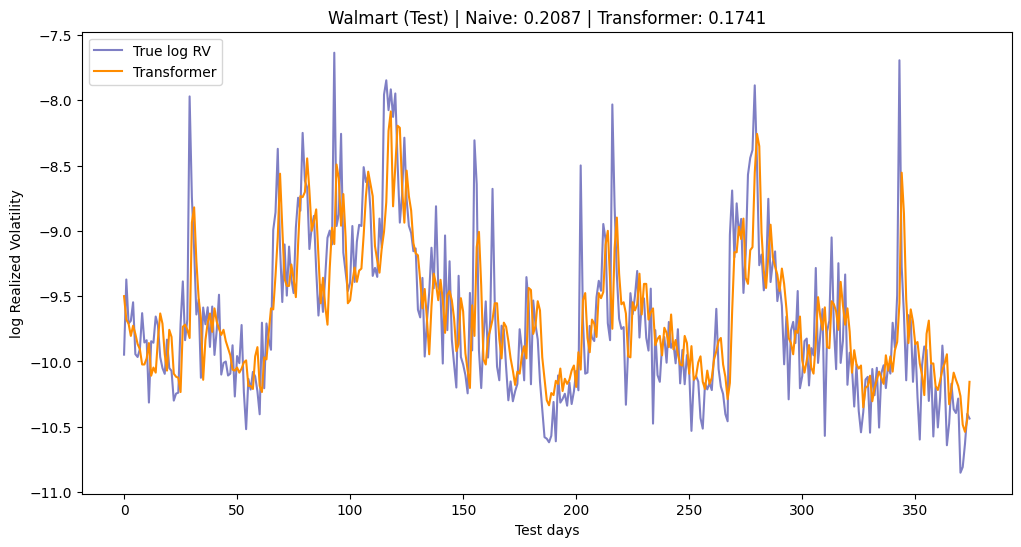

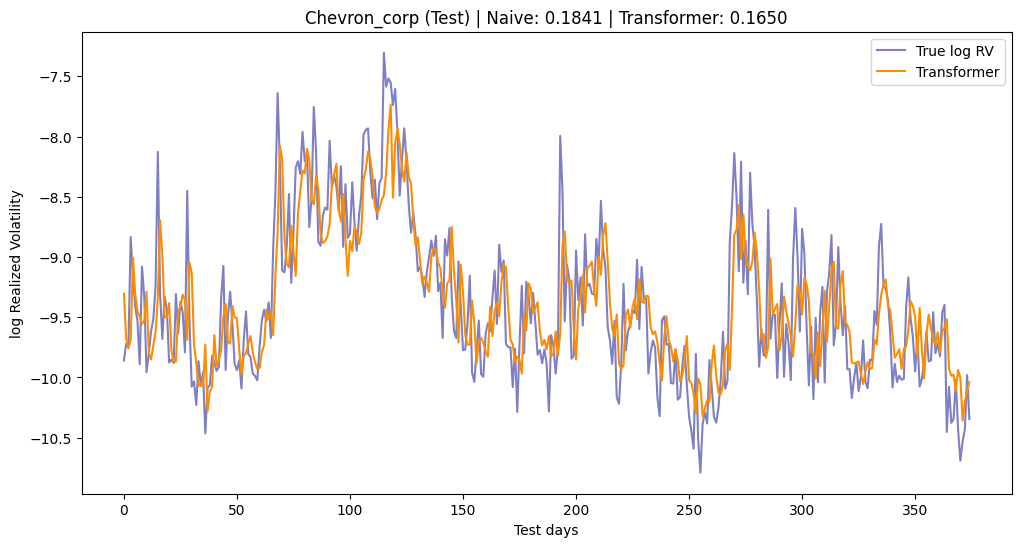

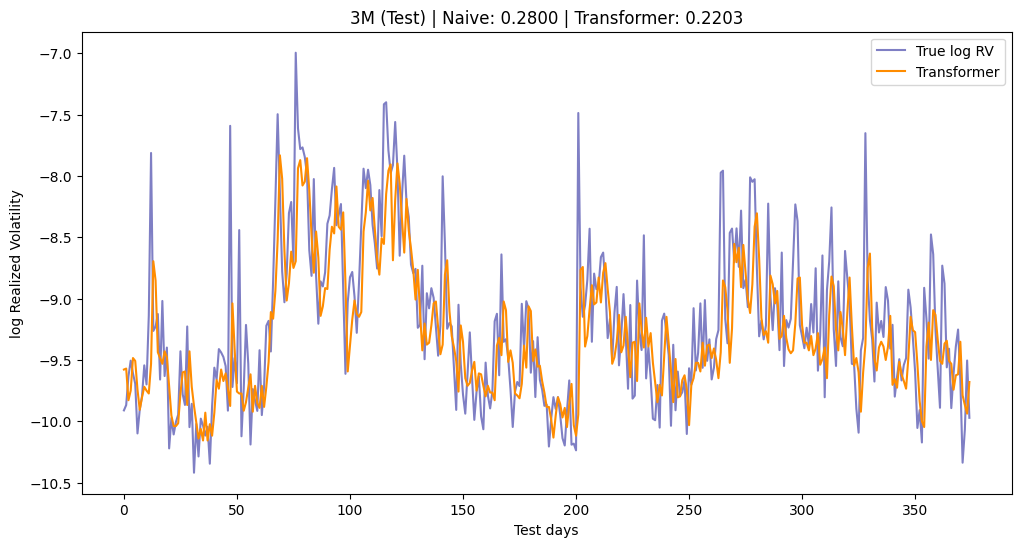

In [175]:
result_dic, model_MSE_avg, naive_MSE_avg = run_test(model, X_test_dic, y_test_dic)

# HAR & Naive DM-Test

In [211]:
for stock in result_dic.keys():
  har_out = fit_har_baseline(har_train[stock], result_dic[stock]["y_test"])
  print("HAR DM-Test")
  print(dm_test(result_dic[stock]["y_test"], har_out[0], result_dic[stock]["y_pred"]))
  print("HAR MSE:")
  print(np.mean((har_out[0] - result_dic[stock]["y_test"])**2))
  print("Stock MSE:")
  print(np.mean((result_dic[stock]["y_pred"] - result_dic[stock]["y_test"])**2))

HAR DM-Test
(np.float64(-0.8274001575669853), np.float64(0.4085364916714298))
HAR MSE:
0.16861151986804696
Stock MSE:
0.1741410828415433
HAR DM-Test
(np.float64(-2.370471111094514), np.float64(0.018270476828248162))
HAR MSE:
0.15162939401069003
Stock MSE:
0.1650389630172235
HAR DM-Test
(np.float64(-0.444632024617917), np.float64(0.6568422054307484))
HAR MSE:
0.21640954489413183
Stock MSE:
0.220336790300736


In [204]:
for stock in result_dic.keys():
  print("Stock DM-Test")
  print(dm_test(result_dic[stock]["y_test"], result_dic[stock]["naive_pred"], result_dic[stock]["y_pred"]))
  print("Naive MSE:")
  print(np.mean((result_dic["Walmart"]["naive_pred"][1:] - result_dic["Walmart"]["y_test"][1:])**2))
  print("Stock MSE:")
  print(np.mean((result_dic["Walmart"]["y_pred"] - result_dic["Walmart"]["y_test"])**2))

Stock DM-Test
(np.float64(3.0509267322888207), np.float64(0.002443691172469599))
Naive MSE:
0.20870408208977037
Stock MSE:
0.1741410828415433
Stock DM-Test
(np.float64(2.200691690456261), np.float64(0.028366856003299936))
Naive MSE:
0.20870408208977037
Stock MSE:
0.1741410828415433
Stock DM-Test
(np.float64(3.0774609666066546), np.float64(0.002241184697109067))
Naive MSE:
0.20870408208977037
Stock MSE:
0.1741410828415433


In [189]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

# ==============================================================================
# 1. HAR BASELINE MODEL
# ==============================================================================

def har_features(log_rv: pd.Series):
    """
    Builds correct 1-day-ahead HAR features from a log realized volatility series.
    """
    df = pd.DataFrame({"log_rv": log_rv})

    # Target: Realized Volatility of the next day (t+1)
    df["y_tomorrow"] = df["log_rv"].shift(-1)

    # Predictors from day t (the most recent available information)
    df["har_1"] = df["log_rv"]                              # Daily component
    df["har_5"] = df["log_rv"].rolling(5).mean()             # Weekly average
    df["har_22"] = df["log_rv"].rolling(22).mean()           # Monthly average

    df = df.dropna()
    return df

def fit_har_baseline(y_train, y_test):
    """
    Trains a HAR model on training data and predicts on test data.

    Args:
        y_train (np.array): Array of training log_rv targets.
        y_test (np.array): Array of testing log_rv targets.

    Returns:
        tuple: (HAR model predictions on the test set, fitted model summary)
    """
    # Create a single continuous series for feature engineering
    full_series = pd.Series(np.concatenate([y_train, y_test]))

    # Generate HAR features for the entire dataset
    df_har = har_features(full_series)

    # Re-create the chronological split
    n_train = len(y_train)
    # Adjust for NaNs dropped at the beginning by har_features
    train_end_idx = n_train - (len(full_series) - len(df_har))

    train_set = df_har.iloc[:train_end_idx]
    test_set = df_har.iloc[train_end_idx:]

    # --- Train the model ONLY on the training set ---
    X_train = sm.add_constant(train_set[["har_1", "har_5", "har_22"]])
    y_train_har = train_set["y_tomorrow"]

    model = sm.OLS(y_train_har, X_train).fit()

    # --- Predict on the test set ---
    X_test = sm.add_constant(test_set[["har_1", "har_5", "har_22"]])
    predictions = model.predict(X_test).to_numpy()

    # Ensure prediction length matches y_test length (it might be off by one due to target shift)
    # The actual ground truth for the test predictions is y_test
    # Note: `y_tomorrow` in test_set corresponds to the original y_test values

    return predictions, model.summary()

In [187]:
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of
#   prediction mean squared errors. International Journal of forecasting,
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy,
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return rt

<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-821010393.py:72: SyntaxWarning: invalid escape sequence '\d'
  comp = re_compile("^\d+?\.\d+?$")


In [188]:
from scipy.stats import t
import numpy as np

def dm_test(actuals, preds1, preds2, h=1, loss_func='squared_error'):
    """
    Performs the Diebold-Mariano test to compare the predictive accuracy of two forecasts.

    Parameters:
    - actuals (np.array): Array of actual values.
    - preds1 (np.array): Array of predictions from model 1.
    - preds2 (np.array): Array of predictions from model 2.
    - h (int): The forecast horizon. Default is 1.
    - loss_func (str): The loss function to use ('squared_error' or 'absolute_error').

    Returns:
    - dm_statistic (float): The Diebold-Mariano test statistic.
    - p_value (float): The p-value for the test.
    """
    if loss_func == 'squared_error':
        e1 = (actuals - preds1) ** 2
        e2 = (actuals - preds2) ** 2
    elif loss_func == 'absolute_error':
        e1 = np.abs(actuals - preds1)
        e2 = np.abs(actuals - preds2)
    else:
        raise ValueError("loss_func must be 'squared_error' or 'absolute_error'")

    # Calculate the loss differential
    d = e1 - e2
    T = len(d)

    # Calculate the mean and variance of the loss differential
    d_mean = np.mean(d)
    # Newey-West estimator for the variance
    gamma0 = np.var(d, ddof=0)
    if h > 1:
        gamma_h = [np.cov(d[i:], d[:T-i])[0, 1] for i in range(1, h)]
        autocov_sum = np.sum(gamma_h)
        d_var = gamma0 + 2 * autocov_sum
    else:
        d_var = gamma0

    # Calculate the DM statistic
    dm_statistic = d_mean / np.sqrt(d_var / T)

    # Calculate the p-value using a two-sided t-test
    p_value = 2 * t.cdf(-np.abs(dm_statistic), df=T - 1)

    return dm_statistic, p_value
